In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd

## CSV

In [3]:
tracks_df = pd.read_csv('data/spotify_2017.csv', usecols=['artists', 'name'])

In [4]:
tracks_df.head()

,name,artists
0,Shape of You,Ed Sheeran
1,Despacito - Remix,Luis Fonsi
2,Despacito (Featuring Daddy Yankee),Luis Fonsi
3,Something Just Like This,The Chainsmokers
4,I'm the One,DJ Khaled


## API

In [5]:
from music import fetch_lyrics

In [10]:
fetch_lyrics('The Beatles', "Wouldn't it be nice")

''

In [25]:
%%time
tracks_df['lyrics'] = ""
for index, row in tracks_df.head(5).iterrows():
    print(f"Fetching lyrics for {row['artists']} - {row['name']}")
    lyrics = fetch_lyrics(row['artists'], row['name'])
    tracks_df.loc[index,'lyrics'] = lyrics

Fetching lyrics for Ed Sheeran - Shape of You
Fetching lyrics for Luis Fonsi - Despacito - Remix
Fetching lyrics for Luis Fonsi - Despacito (Featuring Daddy Yankee)
Fetching lyrics for The Chainsmokers - Something Just Like This
Fetching lyrics for DJ Khaled - I'm the One


In [16]:
tracks_df.head()

,name,artists,lyrics
0,Shape of You,Ed Sheeran,The club isn't the best place to find a lover\...
1,Despacito - Remix,Luis Fonsi,
2,Despacito (Featuring Daddy Yankee),Luis Fonsi,
3,Something Just Like This,The Chainsmokers,I've been reading books of old\nThe legends an...
4,I'm the One,DJ Khaled,[DJ Khaled:]\nWe The Best Music\nAnother One!\...


In [24]:
tracks_df.loc[0,'name']

'Shape of You'

## SQL

In [26]:
import pandas as pd
import sqlite3
conn = sqlite3.connect("data/soccer.sqlite")

In [30]:
# OLD WAY
cursor = conn.cursor()
cursor.execute('''    SELECT l.id, l.name, c.name as country_name
    FROM League l
    JOIN Country c ON c.id = l.country_id''')
print(cursor.fetchall())

[(1, 'Belgium Jupiler League', 'Belgium'), (1729, 'England Premier League', 'England'), (4769, 'France Ligue 1', 'France'), (7809, 'Germany 1. Bundesliga', 'Germany'), (10257, 'Italy Serie A', 'Italy'), (13274, 'Netherlands Eredivisie', 'Netherlands'), (15722, 'Poland Ekstraklasa', 'Poland'), (17642, 'Portugal Liga ZON Sagres', 'Portugal'), (19694, 'Scotland Premier League', 'Scotland'), (21518, 'Spain LIGA BBVA', 'Spain'), (24558, 'Switzerland Super League', 'Switzerland')]


In [28]:
# NEW WAY
league_df = pd.read_sql(
    '''
    SELECT l.id, l.name, c.name as country_name
    FROM League l
    JOIN Country c ON c.id = l.country_id
    ''', conn)

In [29]:
league_df

,id,name,country_name
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy
5,13274,Netherlands Eredivisie,Netherlands
6,15722,Poland Ekstraklasa,Poland
7,17642,Portugal Liga ZON Sagres,Portugal
8,19694,Scotland Premier League,Scotland
9,21518,Spain LIGA BBVA,Spain


## Google Big Query

In [31]:
import pandas_gbq

In [32]:
project_id = 'bootcamps-august' # TODO: replace with your own!

sql = """
SELECT faa_identifier, name, longitude, latitude, airport_type, service_city, country
FROM `bigquery-public-data.faa.us_airports`
WHERE airport_use = 'Public'
"""
airports_df = pandas_gbq.read_gbq(sql, project_id=project_id)

Downloading: 100%|██████████████████████| 5368/5368 [00:01<00:00, 5004.10rows/s]


In [33]:
airports_df.head()

,faa_identifier,name,longitude,latitude,airport_type,service_city,country
0,X01,Everglades Arpk,-81.390281,25.848866,Aerodome,Everglades,United States
1,0C8,Cushing Fld Ltd,-88.605635,41.519483,Aerodome,Newark,United States
2,7L8,Post-Air,-86.013876,39.750050,Aerodome,Indianapolis,United States
3,71K,Westport,-97.383702,37.647701,Aerodome,Wichita,United States
4,2M7,Hoffman's Black Mountain Aerodrome,-84.308061,45.531953,Aerodome,Cheboygan,United States


## Scraping

In [34]:
import requests
from bs4 import BeautifulSoup
import re

In [35]:
url = 'https://www.imdb.com/list/ls055386972/'
response = requests.get(url)

In [41]:
soup = BeautifulSoup(response.content, 'html.parser')

In [43]:
movies_raw = soup.find_all('div', class_='lister-item-content')

In [59]:
movies = []
for movie in movies_raw:
    title = movie.find('h3', class_='lister-item-header').find('a').string
    runtime = int(movie.find('span', class_='runtime').string.strip(' min'))
    year = int(re.search('\d{4}', movie.find('span', class_='lister-item-year').string).group(0))
    movies.append({'title': title, 'runtime': runtime, 'year':year})

In [61]:
movies_df = pd.DataFrame(movies)

In [62]:
movies_df.head()

,title,runtime,year
0,The Godfather,175,1972
1,Schindler's List,195,1993
2,12 Angry Men,96,1957
3,Life Is Beautiful,116,1997
4,"The Good, the Bad and the Ugly",148,1966


In [63]:
def fetch_page(page):
    response = requests.get(
        "https://www.imdb.com/search/title/",
        params={"groups":"top_250", "sort":"user_rating","start": (1 + page * 50)})
    soup = BeautifulSoup(response.content, "html.parser")
    return soup

In [64]:
def parse_movies(soup):
    movies = []
    for movie in soup.find_all("div", class_="lister-item-content"):
        title = movie.find("h3").find("a").string
        duration = int(movie.find(class_="runtime").string.strip(' min'))
        year = int(re.search(r"\d{4}", movie.find(class_="lister-item-year").string).group(0))
        movies.append({'title': title, 'duration': duration, 'year': year})
    return movies

In [65]:
all_movies = []
for page in range(5):
    print(f"Parsing page {page + 1}...")
    soup = fetch_page(page)
    all_movies += parse_movies(soup)
print("Done")

Parsing page 1...
Parsing page 2...
Parsing page 3...
Parsing page 4...
Parsing page 5...
Done


In [69]:
all_movies_df = pd.DataFrame(all_movies)

array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'year'}>]], dtype=object)

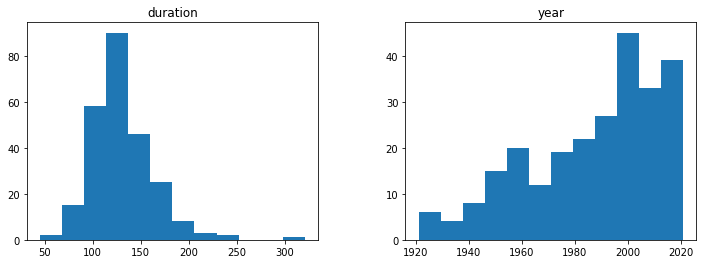

In [71]:
all_movies_df.hist(grid=False, bins=12, figsize=(12, 4))
